In [ ]:
import pandas as pd
import json
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF

In [ ]:
START_PATTERNS = [
    re.compile(r"^\s*Province\s*(?::|\s|of)?\s*(.*)$", re.I),
    re.compile(r"^\s*(?:(?!City,)(?:City|Municipality))(?:\s*/\s*(?:City|Municipality))?\s*[:\s]?\s*(.*)$", re.I),
    re.compile(r"^\s*(?:Barangays?|Zone|Barangay)(?:\s*/\s*(?:Barangays?|Zone|Barangay))?\s*[:\s]?\s*(.*)$", re.I),
    re.compile(r"^\s*S\s*T\s*R\s*E\s*E\s*T\s*N\s*A\s*M\s*E\s*$", re.I),    # “STREETNAME” with spaces between letters
]


In [2]:
ZV_PATTERN_REGEX = re.compile(
    r"\d+(?:ST|ND|RD|TH)\s+(?:REVISION|Rev)(?:.*Z\.?V\.?.*SQ.*M\.?)?|"
    r"(?:\d+(?:ST|ND|RD|TH)\s+REVISION|Rev\s+ZV\s+/?.*SQ\.?\s*M\.?)|"
    r"(?:Z|2)\.?V\.?.*SQ.*M\.?|FINAL",
    re.IGNORECASE
)

In [3]:
VOCAB_SIZE = 20000
EMBEDDING_DIM = 192
TEXT_SEQ_OUTPUT_LEN = 50
LSTM_HIDDEN_DIM = 256
BATCH_SIZE = 2
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

# Feature Engineering

In [4]:
def is_numeric_str(s: str) -> bool:
    if not s: return False
    s = re.sub(r'[₱,]', '', s)
    try:
        float(s)
        return True
    except ValueError:
        return False


def extract_single_row_features(raw_cells_list: list[str]) -> dict:
    scalar_features_dict = {}
    
    non_whitespace_cells_texts = [str(cell_text) for cell_text in raw_cells_list if
                                  cell_text is not None and str(cell_text).strip() != ""]
    
    concatenated_text = " ".join(non_whitespace_cells_texts)
    
    scalar_features_dict['num_cells_in_row'] = float(len(raw_cells_list))
    
    first_non_null_idx = -1
    for i, cell_text in enumerate(raw_cells_list):
        if cell_text is not None and str(cell_text).strip() != "":
            first_non_null_idx = i
            break
    scalar_features_dict['first_non_null_column'] = float(first_non_null_idx)
    
    last_non_null_idx = -1
    for i in range(len(raw_cells_list) - 1, -1, -1):
        cell_text = raw_cells_list[i]
        if cell_text is not None and str(cell_text).strip() != "":
            last_non_null_idx = i
            break
    scalar_features_dict['last_non_null_column'] = float(last_non_null_idx)
    
    scalar_features_dict['num_non_empty_cells'] = float(len(non_whitespace_cells_texts))
    
    if scalar_features_dict['num_cells_in_row'] > 0:
        scalar_features_dict['ratio_non_empty_cells'] = scalar_features_dict['num_non_empty_cells'] / \
                                                        scalar_features_dict['num_cells_in_row']
    else:
        scalar_features_dict['ratio_non_empty_cells'] = 0.0
        
    numeric_cell_count = sum(1 for text in non_whitespace_cells_texts if is_numeric_str(text))
    scalar_features_dict['num_numeric_cells'] = float(numeric_cell_count)
    
    if scalar_features_dict['num_non_empty_cells'] > 0:
        scalar_features_dict['ratio_numeric_cells'] = numeric_cell_count / scalar_features_dict['num_non_empty_cells']
    else:
        scalar_features_dict['ratio_numeric_cells'] = 0.0
        
    scalar_features_dict['is_row_empty_or_whitespace_only'] = 1.0 if scalar_features_dict[
                                                                         'num_non_empty_cells'] == 0 else 0.0
    scalar_features_dict['is_all_caps'] = 1.0 if concatenated_text.isupper() else 0.0
    first_cell_raw = str(raw_cells_list[0]) if raw_cells_list and raw_cells_list[0] is not None else ""
    
        
    KEYWORD_MAP = {
        'province': START_PATTERNS[0],
        'city_or_municipality': START_PATTERNS[1],
        'barangay_zone': START_PATTERNS[2],
        'streetname_spaced': START_PATTERNS[3],
    }
    for label, pat in KEYWORD_MAP.items():
        scalar_features_dict[f'starts_with_keyword_{label}'] = 1.0 if pat.match(first_cell_raw) else 0.0
        
    raw_concatenated_for_zv = " ".join(str(cell) for cell in raw_cells_list if cell is not None)
    scalar_features_dict['contains_keyword_zv'] = 1.0 if bool(ZV_PATTERN_REGEX.search(raw_concatenated_for_zv)) else 0.0
    feature_order = [
                        'num_cells_in_row', 'first_non_null_column', 'last_non_null_column',
                        'num_non_empty_cells', 'ratio_non_empty_cells', 'num_numeric_cells',
                        'ratio_numeric_cells', 'is_row_empty_or_whitespace_only', 'contains_keyword_zv',
                        'is_all_caps'
                    ] + [f'starts_with_keyword_{kw}' for kw in KEYWORD_MAP.keys()]
    numeric_features_list = [scalar_features_dict.get(fname, 0.0) for fname in feature_order]
    return {
        'concatenated_text_clean': concatenated_text,
        'numeric_features': np.array(numeric_features_list, dtype=np.float32)
    }

# Text Vectorization

TODO
- out of vocab
- save to memory make it persist for reuse

implement smth like this so we can tokenize important abbr like zv if needed
```
def tokenize(self, text):
    # Preserve important spreadsheet tokens like "Z.V."
    preserved_tokens = re.findall(r'[A-Z]\.?[A-Z]\.?(?:/[A-Z]\.?[A-Z]\.?)?', text)
    # Replace them temporarily
    for i, token in enumerate(preserved_tokens):
        text = text.replace(token, f"__PRESERVED_{i}__")
    
    # Standard tokenization
    tokens = text.lower().split()
    
    # Restore preserved tokens
    for i, token in enumerate(preserved_tokens):
        for j, t in enumerate(tokens):
            if t == f"__preserved_{i}__":
                tokens[j] = token
    
    return tokens
```

In [5]:
class TextVectorizer:
    def __init__(self, max_tokens=VOCAB_SIZE, output_sequence_length=TEXT_SEQ_OUTPUT_LEN):
        self.max_tokens = max_tokens
        self.output_sequence_length = output_sequence_length
        self.vocab = {}
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.pad_token_id = 0
        self.unk_token_id = 1

    def fit_on_texts(self, texts: List[str]):
        word_counts = Counter()
        for text in texts:
            word_counts.update(text.lower().split())

        # Keep most common words, reserve for pad and unk
        common_words = [word for word, count in word_counts.most_common(self.max_tokens - 2)]
        self.token_to_idx = {PAD_TOKEN: self.pad_token_id, UNK_TOKEN: self.unk_token_id}
        for i, token in enumerate(common_words):
            self.token_to_idx[token] = i + 2  # Start after pad and unk
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
        self.vocab_size = len(self.token_to_idx)
        print(f"Vocabulary size: {self.vocab_size}")

    def texts_to_sequences(self, texts: List[str]) -> List[List[int]]:
        sequences = []
        for text in texts:
            tokens = text.lower().split()
            seq = [self.token_to_idx.get(token, self.unk_token_id) for token in tokens]
            # Pad or truncate individual row text sequence
            if len(seq) < self.output_sequence_length:
                seq.extend([self.pad_token_id] * (self.output_sequence_length - len(seq)))
            else:
                seq = seq[:self.output_sequence_length]
            sequences.append(seq)
        return sequences

### Load annotations

In [6]:
annotations_filename = "annotations.csv"
annotations_row_data = 'raw_cells_json'

TODO:
- replace iterrows
```
feature_series = df_annotations['raw_cells_list'] \
    .apply(extract_single_row_features)
df_processed = pd.DataFrame(feature_series.tolist())
df_processed[['text','numerics']].apply(pd.Series)
```

In [7]:
df_annotations = pd.read_csv(annotations_filename)

In [8]:
df_annotations['raw_cells_list'] = df_annotations[annotations_row_data].apply(
    lambda x: json.loads(x) if pd.notna(x) else [])

In [9]:
df_annotations

,filename,sheetname,row_index,label,raw_cells_json,raw_cells_list
0,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023),0,OTHER,"[""Republic of the Philippines"", """", """", """"]","[Republic of the Philippines, , , ]"
1,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023),1,OTHER,"[""DEPARTMENT OF FINANCE"", """", """", """"]","[DEPARTMENT OF FINANCE, , , ]"
2,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023),2,OTHER,"[""MANILA"", """", """", """"]","[MANILA, , , ]"
3,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023),3,BLANK,"["""", """", """", """"]","[, , , ]"
4,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023),4,OTHER,"[""DEPARTMENT ORDER NO. 047 - 2023"", """", """", """"]","[DEPARTMENT ORDER NO. 047 - 2023, , , ]"
...,...,...,...,...,...,...
43094,"RDO No. 96 - Bongao, Tawi-Tawi.xls",Sheet 5 (DO 45-23),849,BLANK,"["""", """", """", """"]","[, , , ]"
43095,"RDO No. 96 - Bongao, Tawi-Tawi.xls",Sheet 5 (DO 45-23),850,BLANK,"["""", """", """", """"]","[, , , ]"
43096,"RDO No. 96 - Bongao, Tawi-Tawi.xls",Sheet 5 (DO 45-23),851,OTHER,"[""I-3/APMD (fpt/10-18-2023)"", """", """", """"]","[I-3/APMD (fpt/10-18-2023), , , ]"
43097,"RDO No. 96 - Bongao, Tawi-Tawi.xls",Sheet 5 (DO 45-23),852,BLANK,"["""", """", """", """"]","[, , , ]"


In [10]:
extract_single_row_features(df_annotations['raw_cells_list'][7])

{'concatenated_text_clean': '',
 'numeric_features': array([ 4., -1., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.], dtype=float32)}

In [11]:
all_row_data = []
for index, row in df_annotations.iterrows():
    features = extract_single_row_features(row['raw_cells_list'])
    all_row_data.append({
        'text': features['concatenated_text_clean'],
        'numerics': features['numeric_features'],
        'label': row['label'],
        'filename': row['filename'],
        'sheetname': row['sheetname']
    })
df_processed_rows = pd.DataFrame(all_row_data)

In [12]:
df_processed_rows.head()

,text,numerics,label,filename,sheetname
0,Republic of the Philippines,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
1,DEPARTMENT OF FINANCE,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
2,MANILA,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
3,,"[4.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...",BLANK,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
4,DEPARTMENT ORDER NO. 047 - 2023,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)


## Group by sheet

TODO
- Think about storing metadata for future downstream use


In [35]:
print("Grouping rows into sequences (sheets)...")
sheet_sequences_text_raw = []
sheet_sequences_numerics = []
sheet_sequences_labels_str = []
sheet_sequences_filenames = []
sheet_sequences_sheetnames = []

for (fname, sname), group in df_processed_rows.groupby(['filename', 'sheetname']):
    sheet_sequences_text_raw.append(group['text'].tolist())
    sheet_sequences_numerics.append(np.stack(group['numerics'].values))
    sheet_sequences_labels_str.append(group['label'].tolist())
    sheet_sequences_filenames.append(fname) 
    sheet_sequences_sheetnames.append(sname)

Grouping rows into sequences (sheets)...


# Label Encoding

In [14]:
df_processed_rows.head()

,text,numerics,label,filename,sheetname
0,Republic of the Philippines,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
1,DEPARTMENT OF FINANCE,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
2,MANILA,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
3,,"[4.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...",BLANK,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)
4,DEPARTMENT ORDER NO. 047 - 2023,"[4.0, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0,...",OTHER,"RDO No. 1 - Laoag City, Ilocos Norte.xls",Sheet 9 (DO 047-2023)


In [15]:
all_unique_labels = sorted(list(set(label for seq in sheet_sequences_labels_str for label in seq)))
label_encoder = LabelEncoder()
label_encoder.fit(all_unique_labels)
n_classes = len(label_encoder.classes_)
LABEL_PAD_ID = -1  # or n_classes, but ensure consistency
print(f"Found {n_classes} unique classes: {label_encoder.classes_}. Using {LABEL_PAD_ID} as label padding ID.")

Found 7 unique classes: ['BLANK' 'DATA' 'HDR' 'LOC_B' 'LOC_C' 'LOC_P' 'OTHER']. Using -1 as label padding ID.


In [16]:
sheet_sequences_labels_encoded = [
    label_encoder.transform(seq) for seq in sheet_sequences_labels_str
]

In [17]:
# Analyze label transitions
print("\nAnalyzing common label transitions...")
transitions = Counter()
for label_seq in sheet_sequences_labels_str:
    for i in range(len(label_seq) - 1):
        transitions[(label_seq[i], label_seq[i+1])] += 1

print("Top 5 most common transitions:")
for (from_label, to_label), count in transitions.most_common(5):
    print(f"- {from_label} → {to_label}: {count}")


Analyzing common label transitions...
Top 5 most common transitions:
- DATA → DATA: 22591
- OTHER → OTHER: 4135
- OTHER → BLANK: 2227
- BLANK → BLANK: 1878
- BLANK → OTHER: 1549


# Text Vectorization

In [18]:
all_texts_for_vocab = [text for seq in sheet_sequences_text_raw for text in seq]
text_vectorizer = TextVectorizer(max_tokens=VOCAB_SIZE, output_sequence_length=TEXT_SEQ_OUTPUT_LEN)
text_vectorizer.fit_on_texts(all_texts_for_vocab)

# Convert sheet texts to sequences of token IDs
sheet_sequences_text_ids = []
for sheet_texts in sheet_sequences_text_raw:
    sheet_sequences_text_ids.append(
        np.array(text_vectorizer.texts_to_sequences(sheet_texts), dtype=np.int64)
    )

Vocabulary size: 10202


# n_numeric_features Definition

In [19]:
_feature_order_for_len_calc = (['num_cells_in_row', 'first_non_null_column', 'last_non_null_column',
                               'num_non_empty_cells', 'ratio_non_empty_cells', 'num_numeric_cells',
                               'ratio_numeric_cells', 'is_row_empty_or_whitespace_only', 'contains_keyword_zv',
                                'is_all_caps'] 
                               + 
                               [f'starts_with_keyword_{kw.lower().replace(" ", "_")}' for kw in KEYWORDS_FOR_STARTS_WITH])
n_numeric_features = len(_feature_order_for_len_calc)
print(f"Number of scalar numeric features per row: {n_numeric_features}")

Number of scalar numeric features per row: 16


In [20]:
indices = np.arange(len(sheet_sequences_text_ids))  # Number of sheets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)
train_indices, val_indices = train_test_split(train_indices, test_size=0.15, random_state=42, shuffle=True)

In [21]:
def get_split_data_pytorch(selected_indices):
    split_texts = [sheet_sequences_text_ids[i] for i in selected_indices]
    split_numerics = [torch.tensor(sheet_sequences_numerics[i], dtype=torch.float32) for i in selected_indices]
    split_labels = [torch.tensor(sheet_sequences_labels_encoded[i], dtype=torch.long) for i in selected_indices]
    # For CRF, we also need original lengths to create masks
    split_lengths = [len(seq) for seq in split_labels]  # Original number of rows in each sheet
    return split_texts, split_numerics, split_labels, split_lengths

In [22]:
train_texts_ids, train_numerics, train_labels, train_lengths = get_split_data_pytorch(train_indices)
val_texts_ids, val_numerics, val_labels, val_lengths = get_split_data_pytorch(val_indices)
test_texts_ids, test_numerics, test_labels, test_lengths = get_split_data_pytorch(test_indices)

In [23]:
print(f"Train sequences: {len(train_texts_ids)}, Val sequences: {len(val_texts_ids)}, Test sequences: {len(test_texts_ids)}")

Train sequences: 9, Val sequences: 2, Test sequences: 3


In [24]:
class TextFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, text_seq_output_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=text_vectorizer.pad_token_id)
        # GlobalAveragePooling1D equivalent for (batch * sheet_len, text_seq_output_len, embedding_dim)
        # We will apply mean over the text_seq_output_len dimension
        # self.pool = nn.AdaptiveAvgPool1d(1) # Could also work if input is (N, C, L)

    def forward(self, text_input_per_row):
        embedded_text = self.embedding(text_input_per_row)
        # Mask out padding tokens before averaging
        mask = (text_input_per_row != text_vectorizer.pad_token_id).unsqueeze(-1).float()  # (N, text_seq_output_len, 1)
        masked_embedded_text = embedded_text * mask
        summed_embeddings = masked_embedded_text.sum(dim=1)
        non_padding_counts = mask.sum(dim=1)
        non_padding_counts = non_padding_counts.clamp(min=1e-9)
        text_features = summed_embeddings / non_padding_counts
        return text_features

# PyTorch Dataset and DataLoader

In [25]:
class SheetDataset(Dataset):
    def __init__(self, texts_ids_list, numerics_list, labels_list, lengths_list):
        self.texts_ids_list = texts_ids_list
        self.numerics_list = numerics_list
        self.labels_list = labels_list
        self.lengths_list = lengths_list

    def __len__(self):
        return len(self.texts_ids_list)

    def __getitem__(self, idx):
        return {
            "texts": torch.tensor(self.texts_ids_list[idx], dtype=torch.long),  # (seq_len_sheet, text_seq_output_len)
            "numerics": self.numerics_list[idx],  # (seq_len_sheet, n_numeric_features)
            "labels": self.labels_list[idx],  # (seq_len_sheet,)
            "length": self.lengths_list[idx]  # scalar, original number of rows in sheet
        }

In [26]:
def collate_fn(batch):
    # Pad sequences within the batch to the max length in that batch
    texts_batch = [item['texts'] for item in batch]
    numerics_batch = [item['numerics'] for item in batch]
    labels_batch = [item['labels'] for item in batch]
    lengths_batch = torch.tensor([item['length'] for item in batch], dtype=torch.long)

    # Pad each type of sequence
    # texts: (batch_size, max_sheet_len_in_batch, text_seq_output_len)
    padded_texts = pad_sequence(texts_batch, batch_first=True, padding_value=text_vectorizer.pad_token_id)
    # numerics: (batch_size, max_sheet_len_in_batch, n_numeric_features)
    padded_numerics = pad_sequence(numerics_batch, batch_first=True, padding_value=0.0)
    # labels: (batch_size, max_sheet_len_in_batch)
    padded_labels = pad_sequence(labels_batch, batch_first=True, padding_value=LABEL_PAD_ID)

    return {
        "texts": padded_texts,
        "numerics": padded_numerics,
        "labels": padded_labels,
        "lengths": lengths_batch
    }

In [27]:
train_dataset = SheetDataset(train_texts_ids, train_numerics, train_labels, train_lengths)
val_dataset = SheetDataset(val_texts_ids, val_numerics, val_labels, val_lengths)
test_dataset = SheetDataset(test_texts_ids, test_numerics, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [28]:
class NumericFeatureExtractor(nn.Module):
    def __init__(self, n_numeric_features):
        super().__init__()
        # Using LayerNorm as a simple normalization.
        self.norm = nn.LayerNorm(n_numeric_features)

    def forward(self, numeric_input_per_row):
        # numeric_input_per_row shape: (N, n_numeric_features)
        return self.norm(numeric_input_per_row)

In [29]:
class RowClassifierSequenceModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, text_seq_output_len,
                 n_numeric_features, lstm_hidden_dim, n_classes):
        super().__init__()
        self.text_branch = TextFeatureExtractor(vocab_size, embedding_dim, text_seq_output_len)
        self.numeric_branch = NumericFeatureExtractor(n_numeric_features)

        self.combined_feature_dim = embedding_dim + n_numeric_features
        self.bilstm = nn.LSTM(self.combined_feature_dim, lstm_hidden_dim,
                              bidirectional=True, batch_first=True)
        self.fc_to_crf = nn.Linear(lstm_hidden_dim * 2, n_classes)  # LSTM output to emission scores
        self.crf = CRF(n_classes, batch_first=True)

    def forward(self, sheet_texts_ids, sheet_numerics, sheet_lengths, targets=None):
        batch_size, max_sheet_len, current_text_seq_len = sheet_texts_ids.shape

        # Reshape for row-wise processing
        texts_flat = sheet_texts_ids.view(-1, current_text_seq_len)
        numerics_flat = sheet_numerics.view(-1, sheet_numerics.shape[2])


        processed_text_flat = self.text_branch(texts_flat)
        processed_numerics_flat = self.numeric_branch(numerics_flat)

        # Reshape back to sequence
        processed_text_sequence = processed_text_flat.view(batch_size, max_sheet_len, -1)
        processed_numeric_sequence = processed_numerics_flat.view(batch_size, max_sheet_len, -1)

        merged_row_features = torch.cat([processed_text_sequence, processed_numeric_sequence], dim=2)

        # Pack padded sequence for LSTM
        packed_input = pack_padded_sequence(merged_row_features, sheet_lengths.cpu(),
                                            batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bilstm(packed_input)
        bilstm_output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=max_sheet_len)

        emissions = self.fc_to_crf(bilstm_output)

        # Create mask for CRF: True for non-padded elements
        mask = torch.arange(max_sheet_len, device=emissions.device).expand(len(sheet_lengths), max_sheet_len) < sheet_lengths.unsqueeze(1).to(emissions.device)

        if targets is not None:
            current_targets = targets.to(emissions.device)
            safe_targets = current_targets.clone()
            safe_targets[current_targets == LABEL_PAD_ID] = 0
            
            loss = -self.crf(emissions, safe_targets, mask=mask, reduction='mean')
            return loss
        else:
            # For inference
            decoded_sequence = self.crf.decode(emissions, mask=mask)
            return decoded_sequence

# Model Initialization

In [30]:
model = RowClassifierSequenceModel(
    vocab_size=text_vectorizer.vocab_size,
    embedding_dim=EMBEDDING_DIM,
    text_seq_output_len=TEXT_SEQ_OUTPUT_LEN,
    n_numeric_features=n_numeric_features,
    lstm_hidden_dim=LSTM_HIDDEN_DIM,
    n_classes=n_classes
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training

In [31]:
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(train_loader):
        texts = batch['texts'].to(DEVICE)
        numerics = batch['numerics'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        lengths = batch['lengths'].to(DEVICE)  # lengths are already on device if collate_fn puts them there

        optimizer.zero_grad()
        loss = model(texts, numerics, lengths, targets=labels)

        if loss is not None:  # Should always be not None during training
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch + 1}/{EPOCHS}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            texts = batch['texts'].to(DEVICE)
            numerics = batch['numerics'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            lengths = batch['lengths'].to(DEVICE)

            loss = model(texts, numerics, lengths, targets=labels)
            if loss is not None:
                total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}] - Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")

Epoch [1/50] - Training Loss: 2380.2604
Epoch [1/50] - Validation Loss: 1134.0374
Epoch [2/50] - Training Loss: 1605.6258
Epoch [2/50] - Validation Loss: 934.4878
Epoch [3/50] - Training Loss: 1302.2190
Epoch [3/50] - Validation Loss: 932.3807
Epoch [4/50] - Training Loss: 1137.2898
Epoch [4/50] - Validation Loss: 774.9575
Epoch [5/50] - Training Loss: 1102.2925
Epoch [5/50] - Validation Loss: 737.4183
Epoch [6/50] - Training Loss: 1057.5791
Epoch [6/50] - Validation Loss: 690.4336
Epoch [7/50] - Training Loss: 778.3025
Epoch [7/50] - Validation Loss: 754.4516
Epoch [8/50] - Training Loss: 691.3276
Epoch [8/50] - Validation Loss: 618.8472
Epoch [9/50] - Training Loss: 645.7747
Epoch [9/50] - Validation Loss: 615.8177
Epoch [10/50] - Training Loss: 521.8310
Epoch [10/50] - Validation Loss: 803.5155
Epoch [11/50] - Training Loss: 443.2047
Epoch [11/50] - Validation Loss: 626.7053
Epoch [12/50] - Training Loss: 415.6338
Epoch [12/50] - Validation Loss: 798.6803
Epoch [13/50] - Training Lo

# Inference

In [32]:
model.eval()
# Get a sample batch
sample_batch = next(iter(test_loader))
texts_sample = sample_batch['texts'].to(DEVICE)
numerics_sample = sample_batch['numerics'].to(DEVICE)
labels_sample_true = sample_batch['labels']  # Keep on CPU for comparison
lengths_sample = sample_batch['lengths'].to(DEVICE)

with torch.no_grad():
    predicted_sequences_encoded = model(texts_sample, numerics_sample, lengths_sample)  # List of lists

# Display predictions for the first sheet in the batch
idx_to_show = 0
if idx_to_show < len(predicted_sequences_encoded):
    pred_tags_for_sheet = predicted_sequences_encoded[idx_to_show]  # This is a list of tag indices
    true_tags_for_sheet = labels_sample_true[idx_to_show][
                          :lengths_sample[idx_to_show]].tolist()  # Get true labels up to original length

    # Find original text for this sample (more involved as DataLoader shuffles)
    # For simplicity, we'll just show predicted vs true tags
    # To get original text, you'd need to map back from test_loader to test_dataset indices or not shuffle test_loader.

    print(f"\nSample Prediction for sheet {idx_to_show} (length {lengths_sample[idx_to_show].item()}):")
    predicted_labels_str = label_encoder.inverse_transform(pred_tags_for_sheet)
    true_labels_str = label_encoder.inverse_transform(true_tags_for_sheet)

    for i in range(lengths_sample[idx_to_show].item()):
        # original_text_snippet = "..." # Would need to fetch original text for this row
        print(f"Row {i}: True='{true_labels_str[i]}', Predicted='{predicted_labels_str[i]}'")
else:
    print("Sample index out of bounds for the batch.")


Sample Prediction for sheet 0 (length 975):
Row 0: True='OTHER', Predicted='OTHER'
Row 1: True='OTHER', Predicted='OTHER'
Row 2: True='OTHER', Predicted='OTHER'
Row 3: True='BLANK', Predicted='BLANK'
Row 4: True='OTHER', Predicted='OTHER'
Row 5: True='OTHER', Predicted='OTHER'
Row 6: True='BLANK', Predicted='BLANK'
Row 7: True='BLANK', Predicted='BLANK'
Row 8: True='LOC_C', Predicted='OTHER'
Row 9: True='OTHER', Predicted='OTHER'
Row 10: True='OTHER', Predicted='OTHER'
Row 11: True='BLANK', Predicted='BLANK'
Row 12: True='OTHER', Predicted='OTHER'
Row 13: True='BLANK', Predicted='BLANK'
Row 14: True='OTHER', Predicted='OTHER'
Row 15: True='OTHER', Predicted='OTHER'
Row 16: True='LOC_B', Predicted='LOC_B'
Row 17: True='OTHER', Predicted='OTHER'
Row 18: True='BLANK', Predicted='BLANK'
Row 19: True='OTHER', Predicted='OTHER'
Row 20: True='LOC_C', Predicted='LOC_C'
Row 21: True='OTHER', Predicted='OTHER'
Row 22: True='BLANK', Predicted='BLANK'
Row 23: True='OTHER', Predicted='OTHER'
Row 2

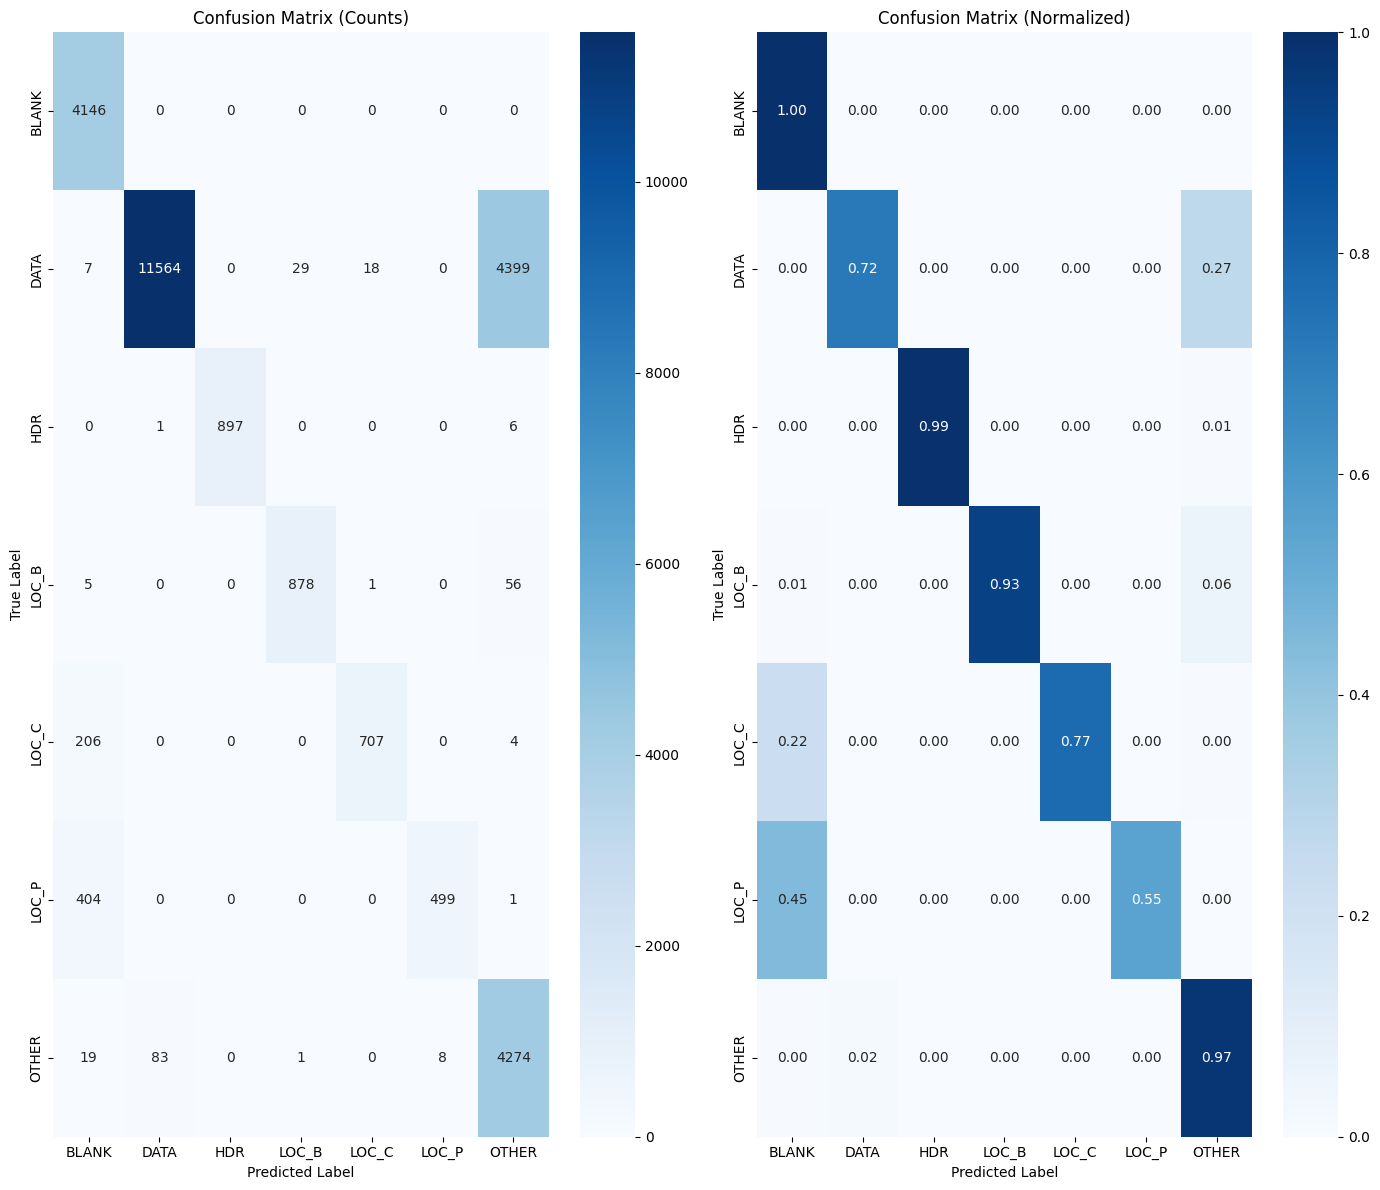

Overall Accuracy: 0.8140

Per-Class Metrics:
------------------
BLANK: Accuracy = 1.0000 (4146/4146)
DATA: Accuracy = 0.7220 (11564/16017)
HDR: Accuracy = 0.9923 (897/904)
LOC_B: Accuracy = 0.9340 (878/940)
LOC_C: Accuracy = 0.7710 (707/917)
LOC_P: Accuracy = 0.5520 (499/904)
OTHER: Accuracy = 0.9747 (4274/4385)


In [33]:
# Code to visualize confusion matrix for your BiLSTM-CRF model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_and_plot_confusion_matrix(model, test_loader, label_encoder, device):
    """
    Computes and plots confusion matrix for the BiLSTM-CRF model.
    
    Args:
        model: The trained BiLSTM-CRF model
        test_loader: DataLoader for the test dataset
        label_encoder: LabelEncoder used to convert between indices and label strings
        device: Device to run inference on (cuda or cpu)
    """
    model.eval()
    
    all_true_labels = []
    all_pred_labels = []
    
    # Iterate through test set and collect predictions
    with torch.no_grad():
        for batch in test_loader:
            texts = batch['texts'].to(device)
            numerics = batch['numerics'].to(device)
            true_labels = batch['labels']  # Keep on CPU for comparison
            lengths = batch['lengths'].to(device)
            
            # Get model predictions
            predicted_sequences_encoded = model(texts, numerics, lengths)
            
            # Process each sequence in the batch
            for i, (pred_seq, true_seq, length) in enumerate(zip(predicted_sequences_encoded, true_labels, lengths)):
                # Only consider actual rows (not padding)
                actual_length = length.item()
                
                # Get true labels up to the actual length and convert to list
                true_seq_trimmed = true_seq[:actual_length].tolist()
                
                # The model prediction is already trimmed to actual length
                pred_seq_trimmed = pred_seq
                
                # Extend our collections
                all_true_labels.extend(true_seq_trimmed)
                all_pred_labels.extend(pred_seq_trimmed)
    
    # Convert label indices to label names for better readability
    class_names = label_encoder.classes_
    all_true_labels_str = label_encoder.inverse_transform(all_true_labels)
    all_pred_labels_str = label_encoder.inverse_transform(all_pred_labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels_str, all_pred_labels_str, labels=class_names)
    
    # Normalize the confusion matrix by row (true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 12))
    
    # Plot regular confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Plot normalized confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall accuracy
    accuracy = np.sum(np.array(all_true_labels_str) == np.array(all_pred_labels_str)) / len(all_true_labels_str)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Calculate per-class metrics
    print("\nPer-Class Metrics:")
    print("------------------")
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        class_total = np.sum(cm[i, :])
        if class_total > 0:
            class_accuracy = true_positives / class_total
            print(f"{class_name}: Accuracy = {class_accuracy:.4f} ({true_positives}/{class_total})")
        else:
            print(f"{class_name}: No instances in test set")

# Call the function with your model and test data
# Use this in a new cell after training your model
compute_and_plot_confusion_matrix(model, test_loader, label_encoder, DEVICE)

In [36]:
# Code to visualize misclassified examples with their original text content
import pandas as pd
import torch
import numpy as np
from IPython.display import display, HTML
from collections import defaultdict

def analyze_misclassifications(model, test_loader, label_encoder, test_dataset, df_processed_rows, device, 
                                true_label_filter=None, pred_label_filter=None, max_examples=10):
    """
    Analyzes misclassified examples and displays their original text content.
    
    Args:
        model: The trained BiLSTM-CRF model
        test_loader: DataLoader for the test dataset
        label_encoder: LabelEncoder used for labels
        test_dataset: The original test dataset
        df_processed_rows: Original dataframe with text content
        device: Device to run inference on
        true_label_filter: Filter for specific true label (e.g., 'DATA')
        pred_label_filter: Filter for specific predicted label (e.g., 'OTHER')
        max_examples: Maximum number of examples to display per misclassification type
    """
    model.eval()
    
    # Dictionary to store misclassifications by type (true_label -> pred_label -> examples)
    misclassifications = defaultdict(lambda: defaultdict(list))
    
    # Map test dataset indices to original dataframe rows
    # This assumes test_indices was used to create test_dataset
    test_files_sheets = []
    
    for idx in test_indices:  # You'll need to have access to test_indices from your train/test split
        # Get the filename and sheetname for this sheet
        filename = sheet_sequences_filenames[idx] if 'sheet_sequences_filenames' in globals() else None
        sheetname = sheet_sequences_sheetnames[idx] if 'sheet_sequences_sheetnames' in globals() else None
        test_files_sheets.append((filename, sheetname))
    
    # Collect predictions and true labels
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            texts = batch['texts'].to(device)
            numerics = batch['numerics'].to(device)
            true_labels = batch['labels']
            lengths = batch['lengths'].to(device)
            
            # Get model predictions
            predicted_sequences_encoded = model(texts, numerics, lengths)
            
            for i, (pred_seq, true_seq, length) in enumerate(zip(predicted_sequences_encoded, true_labels, lengths)):
                # Calculate dataset index for this item in the batch
                dataset_idx = batch_idx * test_loader.batch_size + i
                if dataset_idx >= len(test_dataset):
                    continue  # Skip if we're out of bounds (last batch might be smaller)
                
                # Lookup the original sheet information
                if dataset_idx < len(test_files_sheets):
                    filename, sheetname = test_files_sheets[dataset_idx]
                else:
                    filename, sheetname = None, None
                
                # Get true labels up to actual length
                actual_length = length.item()
                true_seq_trimmed = true_seq[:actual_length].tolist()
                
                # The model prediction is already trimmed to actual length
                pred_seq_trimmed = pred_seq
                
                # Convert to label strings
                true_labels_str = label_encoder.inverse_transform(true_seq_trimmed)
                pred_labels_str = label_encoder.inverse_transform(pred_seq_trimmed)
                
                # Find misclassifications
                for row_idx, (true_label, pred_label) in enumerate(zip(true_labels_str, pred_labels_str)):
                    if true_label != pred_label:
                        # If filters are provided, skip examples that don't match
                        if (true_label_filter and true_label != true_label_filter) or \
                           (pred_label_filter and pred_label != pred_label_filter):
                            continue
                        
                        # Try to find the original text content for this row
                        # This is a simplification - you may need to adjust based on your data organization
                        matching_rows = df_processed_rows[
                            (df_processed_rows['filename'] == filename) & 
                            (df_processed_rows['sheetname'] == sheetname)
                        ]
                        
                        if len(matching_rows) > row_idx:  # Make sure we have enough rows
                            # Find the right row in the original dataset
                            original_text = matching_rows.iloc[row_idx]['text']
                            raw_cells = None
                            
                            # If we have access to the raw cells, get those too
                            if 'raw_cells_list' in matching_rows.columns:
                                raw_cells = matching_rows.iloc[row_idx]['raw_cells_list']
                            
                            misclassifications[true_label][pred_label].append({
                                'text': original_text,
                                'raw_cells': raw_cells,
                                'filename': filename,
                                'sheetname': sheetname,
                                'row_idx': row_idx
                            })
    
    # Display misclassifications
    print("## Misclassified Examples Analysis\n")
    
    total_misclassifications = sum(
        len(examples) for label_dict in misclassifications.values() for examples in label_dict.values()
    )
    print(f"Total misclassifications: {total_misclassifications}\n")
    
    for true_label, pred_dict in sorted(misclassifications.items()):
        for pred_label, examples in sorted(pred_dict.items()):
            print(f"### True: '{true_label}' → Predicted: '{pred_label}' ({len(examples)} examples)")
            
            # Display a sample of examples
            for i, example in enumerate(examples[:max_examples]):
                print(f"\nExample {i+1}:")
                print(f"File: {example['filename']}")
                print(f"Sheet: {example['sheetname']}")
                print(f"Row: {example['row_idx']}")
                print(f"Text: \"{example['text']}\"")
                
                if example['raw_cells']:
                    print("Raw cells:")
                    for cell in example['raw_cells']:
                        print(f"  - {repr(cell)}")
                print("-" * 80)
            
            if len(examples) > max_examples:
                print(f"...and {len(examples) - max_examples} more examples\n")
            print("\n")
    
    # Create a summary DataFrame
    summary_data = []
    for true_label, pred_dict in misclassifications.items():
        for pred_label, examples in pred_dict.items():
            summary_data.append({
                'True Label': true_label,
                'Predicted Label': pred_label,
                'Count': len(examples)
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values(by='Count', ascending=False)
        
        print("### Misclassification Summary")
        display(summary_df)

# Example usage - specific misclassification analysis
# Show examples where the true label is "DATA" but predicted as "OTHER"
print("# Analyzing 'DATA' rows incorrectly classified as 'OTHER'")
analyze_misclassifications(model, test_loader, label_encoder, test_dataset, df_processed_rows, DEVICE, 
                           true_label_filter="DATA", pred_label_filter="OTHER")

# You can also run without filters to see all misclassifications
print("\n# All Misclassifications (limited examples per type)")
analyze_misclassifications(model, test_loader, label_encoder, test_dataset, df_processed_rows, DEVICE)

# Analyzing 'DATA' rows incorrectly classified as 'OTHER'
## Misclassified Examples Analysis

Total misclassifications: 4399

### True: 'DATA' → Predicted: 'OTHER' (4399 examples)

Example 1:
File: RDO No. 53B - Muntinlupa City.xls
Sheet: Sheet 10 (DO 089-2023)
Row: 273
Text: "AYALA ALABANG VILLAGE PHASES 1, 2A,2B , 3A1, 3A2, 3B1, 3B2, 3B3, 4, 5, 6, 7, 8A, 8B, 9, 10A, 10B, 10C, 10D, XI-A, XI-B, XI-C & XII RR 135000"
--------------------------------------------------------------------------------

Example 2:
File: RDO No. 53B - Muntinlupa City.xls
Sheet: Sheet 10 (DO 089-2023)
Row: 276
Text: "LOTS BACKING THE GOLF COURSE PHASES 4 & 2B RR 157000"
--------------------------------------------------------------------------------

Example 3:
File: RDO No. 53B - Muntinlupa City.xls
Sheet: Sheet 10 (DO 089-2023)
Row: 278
Text: "LOTS ALONG THE PERIMETERS OF APITONG, ADELFA, ROSAL, BATANGAS EAST, SOUTH & WEST, TAMARIND, LANGKA, SANTIAGO, & PORTIONS OF SAN JUANICO, GUAVA DRIVE, TAMARIND DRIVE, SA

,True Label,Predicted Label,Count
0,DATA,OTHER,4399



# All Misclassifications (limited examples per type)
## Misclassified Examples Analysis

Total misclassifications: 5248

### True: 'DATA' → Predicted: 'BLANK' (7 examples)

Example 1:
File: RDO No. 1 - Laoag City, Ilocos Norte.xls
Sheet: Sheet 9 (DO 047-2023)
Row: 4038
Text: "A36 70"
--------------------------------------------------------------------------------

Example 2:
File: RDO No. 1 - Laoag City, Ilocos Norte.xls
Sheet: Sheet 9 (DO 047-2023)
Row: 6325
Text: "A1* 415"
--------------------------------------------------------------------------------

Example 3:
File: RDO No. 1 - Laoag City, Ilocos Norte.xls
Sheet: Sheet 9 (DO 047-2023)
Row: 6345
Text: "A1* 415"
--------------------------------------------------------------------------------

Example 4:
File: RDO No. 1 - Laoag City, Ilocos Norte.xls
Sheet: Sheet 9 (DO 047-2023)
Row: 7122
Text: "A1 135"
--------------------------------------------------------------------------------

Example 5:
File: RDO No. 1 - Laoag City, Ilocos 

,True Label,Predicted Label,Count
6,DATA,OTHER,4399
10,LOC_P,BLANK,404
1,LOC_C,BLANK,206
4,OTHER,DATA,83
13,LOC_B,OTHER,56
8,DATA,LOC_B,29
3,OTHER,BLANK,19
7,DATA,LOC_C,18
2,OTHER,LOC_P,8
9,DATA,BLANK,7
